<h1> Predicting No-Show for Hotel Reservation</h1>

<h2>Practical Motivation</h2>

Predicting no-shows for hotel reservations is crucial for optimising hotel operations, enhancing customer experience, and maximising revenue. By accurately forecasting the likelihood of guests not showing up for their bookings, hotels can implement proactive strategies to mitigate the costs of no-shows.

This can help in :  

1. Maximising Revenue: No-shows directly impact a hotel's revenue by resulting in lost room revenue and potential cancellation fees. Predictive models for no-shows allow hotels to overbook rooms within acceptable limits, maximizing occupancy and revenue while minimizing the risk of overbooking.

2. Optimising Resource Allocation: By accurately predicting no-shows, hotels can optimize resource allocation, including staffing levels, room assignments, and inventory management. This ensures that resources are utilized efficiently and effectively, minimizing waste and maximizing profitability.

3. Enhancing Guest Experience: Anticipating no-shows enables hotels to provide a more seamless and personalized experience for guests. By managing expectations and avoiding overbooking situations, hotels can ensure that available resources are allocated to maximize guest satisfaction.

By leveraging predictive analytics and data-driven insights, hotels can achieve greater success and sustainability in today's dynamic business landscape.


<h2>Sample Collection</h2>

In order to conduct accurate predictions of no-shows for hotel reservations, it is imperative to collect a comprehensive dataset that encompasses various relevant features. The sample collection process involves gathering information on past hotel reservations, including booking branch, guest demographics, reservation history, price, booking platform and any other relevant factors that could affect the probability of guest showing up for their reservation.

We obtained our dataset from https://github.com/marmal88/Hotel-Bookings.

<h2>Problem Formulation</h2>

How could we minimise the number of no-shows in order to maintain and increase profits?

Hotel no-shows result in missed revenue opportunities and increased costs due to resource wastage. When guests fail to show up for their reservations, the hotel loses out on potential revenue from the unoccupied rooms. Additionally, the hotel has already incurred costs associated with preparing the room, such as cleaning, maintenance, and staffing. These resources could have been utilized more effectively if the room had been occupied by a paying guest. Moreover, no-shows can lead to overbooking strategies, which may result in guest dissatisfaction and reputational damage for the hotel.

<h2>Data Preparation</h2>

In [123]:
import sqlite3
import pandas as pd

# Establish a connection to the SQLite database
connection = sqlite3.connect('noshow.db')
data = pd.read_sql_query('''SELECT * FROM noshow''', connection)

# Display a sample of the data
data.head()

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,94113,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0.0
1,86543,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0.0
2,75928,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0.0
3,66947,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0.0
4,106390,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0.0


In [124]:
# Display number of rows and data type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119391 entries, 0 to 119390
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   booking_id      119391 non-null  int64  
 1   no_show         119390 non-null  float64
 2   branch          119390 non-null  object 
 3   booking_month   119390 non-null  object 
 4   arrival_month   119390 non-null  object 
 5   arrival_day     119390 non-null  float64
 6   checkout_month  119390 non-null  object 
 7   checkout_day    119390 non-null  float64
 8   country         119390 non-null  object 
 9   first_time      119390 non-null  object 
 10  room            97778 non-null   object 
 11  price           94509 non-null   object 
 12  platform        119390 non-null  object 
 13  num_adults      119390 non-null  object 
 14  num_children    119390 non-null  float64
dtypes: float64(4), int64(1), object(10)
memory usage: 13.7+ MB


From the DataFrame, there are 119391 rows and 15 columns (5 numeric and 10 string/mixed data type)

In [125]:
# Drop rows with missing values
dataCleaned = data.dropna()
dataCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72897 entries, 0 to 119390
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   booking_id      72897 non-null  int64  
 1   no_show         72897 non-null  float64
 2   branch          72897 non-null  object 
 3   booking_month   72897 non-null  object 
 4   arrival_month   72897 non-null  object 
 5   arrival_day     72897 non-null  float64
 6   checkout_month  72897 non-null  object 
 7   checkout_day    72897 non-null  float64
 8   country         72897 non-null  object 
 9   first_time      72897 non-null  object 
 10  room            72897 non-null  object 
 11  price           72897 non-null  object 
 12  platform        72897 non-null  object 
 13  num_adults      72897 non-null  object 
 14  num_children    72897 non-null  float64
dtypes: float64(4), int64(1), object(10)
memory usage: 8.9+ MB


After dropping rows with missing values, the number of rows is reduced to 72897. The 'price' and 'num_adults' should be of numeric data type but are reflected as 'object'. Hence, we shall convert them to floating-point numbers.

In [126]:
# Display unique values of 'num_adults'
uniqueValues = dataCleaned['num_adults'].unique()
print(uniqueValues)

['1' '2' 'one' 'two']


We see that 'num_adults' contains string data type. We shall map them to floating-point numbers.

In [127]:
mapping = {'1': 1.0, '2': 2.0, 'one': 1.0, 'two': 2.0}

# Replace string values with their corresponding float values
dataCleaned['num_adults'] = dataCleaned['num_adults'].replace(mapping)

dataCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72897 entries, 0 to 119390
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   booking_id      72897 non-null  int64  
 1   no_show         72897 non-null  float64
 2   branch          72897 non-null  object 
 3   booking_month   72897 non-null  object 
 4   arrival_month   72897 non-null  object 
 5   arrival_day     72897 non-null  float64
 6   checkout_month  72897 non-null  object 
 7   checkout_day    72897 non-null  float64
 8   country         72897 non-null  object 
 9   first_time      72897 non-null  object 
 10  room            72897 non-null  object 
 11  price           72897 non-null  object 
 12  platform        72897 non-null  object 
 13  num_adults      72897 non-null  float64
 14  num_children    72897 non-null  float64
dtypes: float64(5), int64(1), object(9)
memory usage: 8.9+ MB


C:\Users\Jun Sheng\AppData\Local\Temp\ipykernel_26588\2981498620.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataCleaned['num_adults'] = dataCleaned['num_adults'].replace(mapping)
C:\Users\Jun Sheng\AppData\Local\Temp\ipykernel_26588\2981498620.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataCleaned['num_adults'] = dataCleaned['num_adults'].replace(mapping)


In [128]:
# Display unique values of 'price'
uniqueValues = dataCleaned['price'].unique()
print(uniqueValues)

['SGD$ 492.98' 'SGD$ 1351.22' 'SGD$ 666.04' ... 'USD$ 331.93'
 'USD$ 612.18' 'USD$ 1041.29']


We find that some of the price is in SGD and some in USD. We shall convert all of them to SGD and to floating-point numbers.

In [129]:
# Conversion rate from USD to SGD 
conversion_rate = 1.34

# Remove "USD$" prefix and convert prices starting with "USD$" to float
dataCleaned['price'] = dataCleaned['price'].apply(lambda x: float(x.replace('USD$', '')) if x.startswith('USD$') else x)

# Convert float values to SGD and round to 2 decimal places
dataCleaned['price'] = dataCleaned['price'].apply(lambda x: round(x * conversion_rate, 2) if isinstance(x, float) else x)

# Remove 'SGD$' prefix and convert the prices to float
dataCleaned['price'] = dataCleaned['price'].apply(lambda x: float(x.replace('SGD$ ', '')) if isinstance(x, str) and x.startswith('SGD$') else x)

uniqueValues = dataCleaned['price'].unique()
print(uniqueValues)

[ 492.98 1351.22  666.04 ...  444.79  820.32 1395.33]


C:\Users\Jun Sheng\AppData\Local\Temp\ipykernel_26588\1087060476.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataCleaned['price'] = dataCleaned['price'].apply(lambda x: float(x.replace('USD$', '')) if x.startswith('USD$') else x)
C:\Users\Jun Sheng\AppData\Local\Temp\ipykernel_26588\1087060476.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataCleaned['price'] = dataCleaned['price'].apply(lambda x: round(x * conversion_rate, 2) if isinstance(x, float) else x)
C:\Users\Jun Sheng\AppData\Local\Te

The values in 'price' have been converted to SGD and to floating-point numbers.

In [130]:
# Check current rows and data type
dataCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72897 entries, 0 to 119390
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   booking_id      72897 non-null  int64  
 1   no_show         72897 non-null  float64
 2   branch          72897 non-null  object 
 3   booking_month   72897 non-null  object 
 4   arrival_month   72897 non-null  object 
 5   arrival_day     72897 non-null  float64
 6   checkout_month  72897 non-null  object 
 7   checkout_day    72897 non-null  float64
 8   country         72897 non-null  object 
 9   first_time      72897 non-null  object 
 10  room            72897 non-null  object 
 11  price           72897 non-null  float64
 12  platform        72897 non-null  object 
 13  num_adults      72897 non-null  float64
 14  num_children    72897 non-null  float64
dtypes: float64(6), int64(1), object(8)
memory usage: 8.9+ MB


Now, we see that there are 7 variables containing numeric data types

In [131]:
# Display a quick overview of the numeric data
dataCleaned.describe()

,booking_id,no_show,arrival_day,checkout_day,price,num_adults,num_children
count,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000
mean,59732.828580,0.370742,15.763680,14.202862,938.536424,1.422829,0.872203
std,34477.895527,0.483007,8.782228,11.108107,262.855356,0.494012,0.779978
min,2.000000,0.000000,1.000000,-31.000000,391.290000,1.000000,0.000000
25%,29894.000000,0.000000,8.000000,7.000000,815.270000,1.000000,0.000000
50%,59822.000000,0.000000,16.000000,15.000000,902.340000,1.000000,1.000000
75%,89522.000000,1.000000,23.000000,23.000000,997.280000,2.000000,1.000000
max,119390.000000,1.000000,31.000000,31.000000,2099.960000,2.000000,3.000000


From the statistics, the min and max values of the variables are of the normal range except 'checkout_day' which contains negative values. We shall remove the rows with negative values.

In [132]:
# Keep rows with positive values
dataCleaned = dataCleaned[dataCleaned['checkout_day'] >= 0]

dataCleaned.describe()

,booking_id,no_show,arrival_day,checkout_day,price,num_adults,num_children
count,69357.000000,69357.000000,69357.000000,69357.000000,69357.000000,69357.000000,69357.000000
mean,59706.845135,0.369883,15.758208,15.743804,938.706348,1.423649,0.872529
std,34499.431317,0.482776,8.785792,8.768919,262.996067,0.494140,0.779462
min,2.000000,0.000000,1.000000,1.000000,391.290000,1.000000,0.000000
25%,29808.000000,0.000000,8.000000,8.000000,815.290000,1.000000,0.000000
50%,59804.000000,0.000000,16.000000,16.000000,902.410000,1.000000,1.000000
75%,89551.000000,1.000000,23.000000,23.000000,997.650000,2.000000,1.000000
max,119390.000000,1.000000,31.000000,31.000000,2099.960000,2.000000,3.000000


Now, we see that all the numeric variables contains values within the normal range (i.e. day can only range from 1 to 31).

In [133]:
# Display unique values of 'arrival_month'
uniqueValues = dataCleaned['arrival_month'].unique()
print(uniqueValues)

['June' 'November' 'October' 'March' 'May' 'August' 'July' 'January'
 'April' 'September' 'February' 'December' 'ApRiL' 'OcTobeR' 'JuNe'
 'DecembEr' 'SeptEmber' 'JanUary' 'FeBruary' 'JanuarY' 'SePtember' 'MaY'
 'NoVember' 'JUly' 'JuLy' 'FebrUary' 'SeptemBer' 'OctobeR' 'AugusT' 'JulY'
 'JUne' 'NovembEr' 'APril' 'FEbruary' 'JunE' 'AuGust' 'MarcH' 'OctOber'
 'AUgust' 'AuguSt' 'JanuAry' 'NOveMber' 'MAy' 'MarCh' 'ApriL' 'MaRch'
 'NovemBer' 'MArch' 'JaNuary' 'NovembeR' 'SeptembEr' 'FebruarY'
 'SeptembeR' 'DecembeR' 'OcTober' 'SepTember' 'DEcember' 'FebruaRy'
 'OctoBer' 'OctobEr' 'AugUst' 'JanuaRy' 'NovEmber' 'NOvember' 'DecemBer'
 'DeceMber' 'ApRil' 'NoveMber' 'FebruAry' 'OCtober' 'AprIl' 'DecEmber'
 'SEptember' 'JAnuary' 'SepteMber' 'DeCember' 'MAY' 'FebRuary' 'OCTober'
 'DecEMber' 'FebruaRY' 'NovemBeR' 'NOvEmber']


We also find that the months in 'arrival_month' is not standardised. Hence, we shall convert all the months to lowercase and capitalised the first letter.

In [134]:
dataCleaned['arrival_month'] = dataCleaned['arrival_month'].str.lower().str.capitalize()

# Display results
uniqueValues = dataCleaned['arrival_month'].unique()
print(uniqueValues)

['June' 'November' 'October' 'March' 'May' 'August' 'July' 'January'
 'April' 'September' 'February' 'December']


Preprocessing steps undertaken :
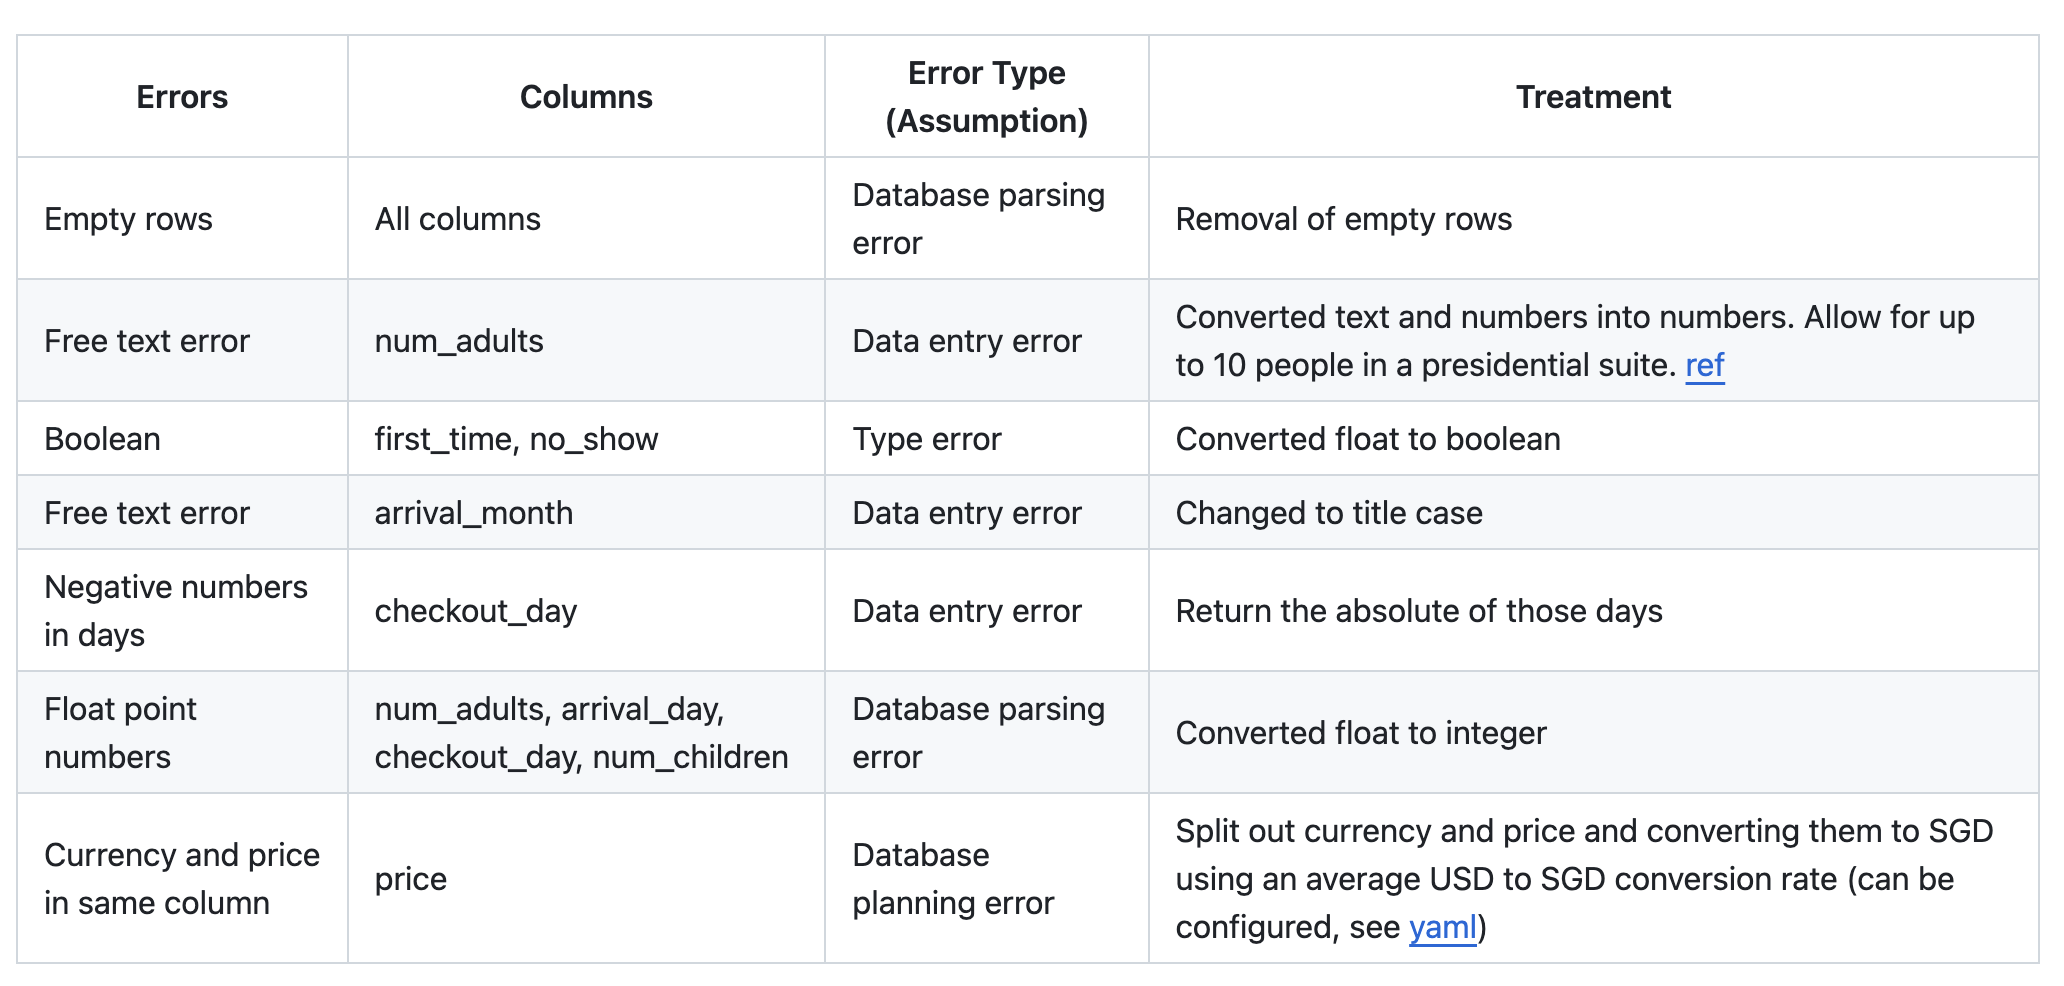

Now that we have cleaned the data, we can proceed to analyse the data to determine the variables that could have a relationship with 'no_show'.

<h2>Exploratory Data Analysis</h2>

This section involves Staistical Description, Analytic Visualisation and Pattern Recognition.

In [135]:
import seaborn as sb
import matplotlib.pyplot as plt

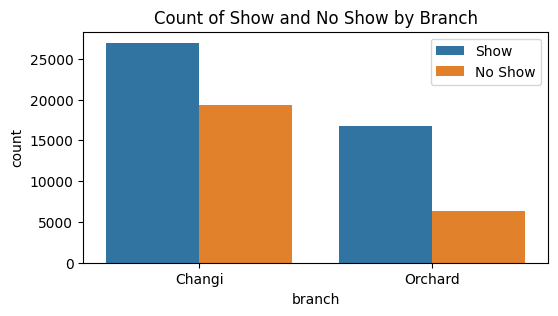

In [136]:
plt.figure(figsize=(6, 3)) 
sb.countplot(x='branch', hue='no_show', data=dataCleaned)
plt.title('Count of Show and No Show by Branch')
plt.legend(labels=['Show', 'No Show'])
plt.show()

We see that the branch in Changi has a higher proportion of No Show compared to Orchard. This could imply some form of relationship between 'no_show' and 'branch'.

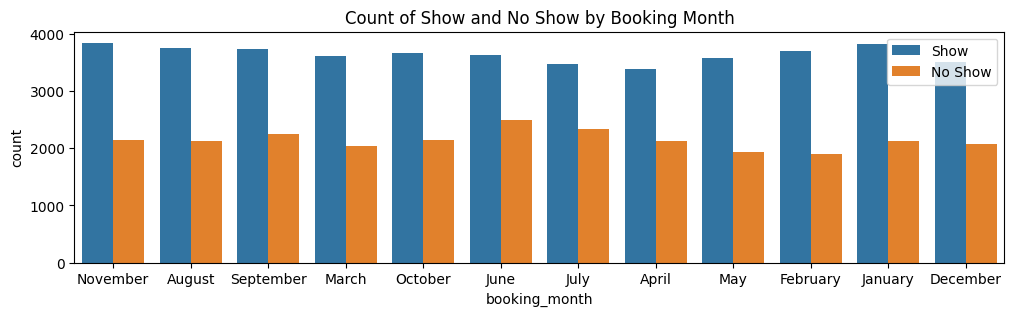

In [137]:
plt.figure(figsize=(12, 3)) 
sb.countplot(x='booking_month', hue='no_show', data=dataCleaned)
plt.title('Count of Show and No Show by Booking Month')
plt.legend(labels=['Show', 'No Show'])
plt.show()

We see that the proportion of No Show is roughly evenly distributed across the months. However, there is a slightly higher proportion of No Show in June and a lower proportion of No Show in Feburary.

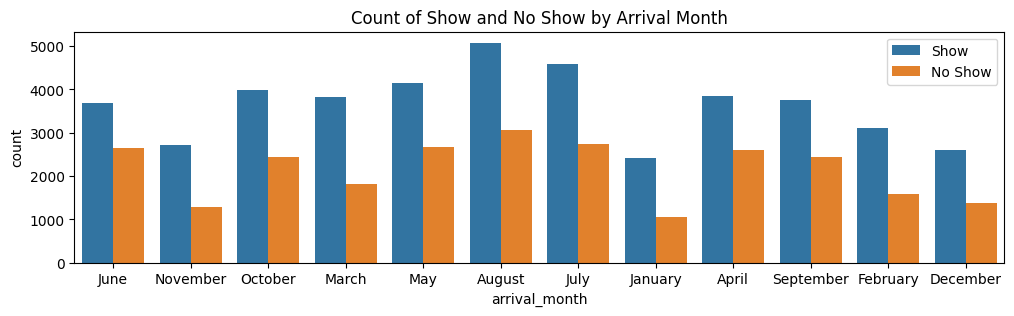

In [138]:
plt.figure(figsize=(12, 3))
sb.countplot(x='arrival_month', hue='no_show', data=dataCleaned)
plt.title('Count of Show and No Show by Arrival Month')
plt.legend(labels=['Show', 'No Show'])
plt.show()

We see a high volume of customers arriving in August. However, the proportion of No Show to Show is generally similar across the months. Hence, it is hard to tell if there is any significant relationship between 'no_show' and 'arrival_month'.

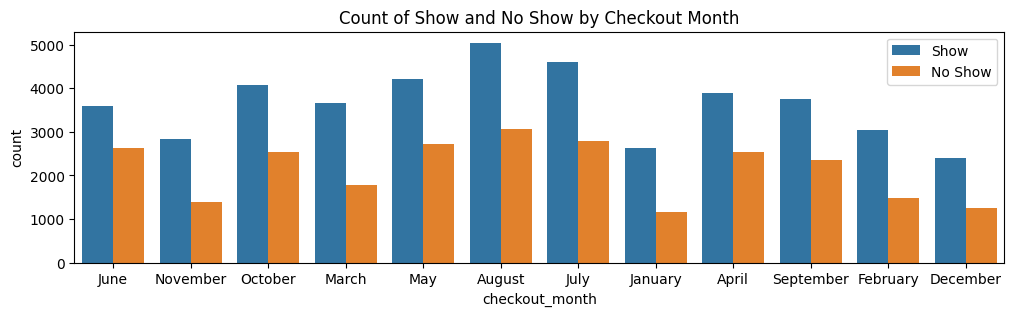

In [139]:
plt.figure(figsize=(12, 3))
sb.countplot(x='checkout_month', hue='no_show', data=dataCleaned)
plt.title('Count of Show and No Show by Checkout Month')
plt.legend(labels=['Show', 'No Show'])
plt.show()

The distribution of Checkout Month is very similar to Arrival Month as it is intuitive that only the customers who showed up during the arrival months would show up during the checkout months (i.e. those who checked in would have checked out).

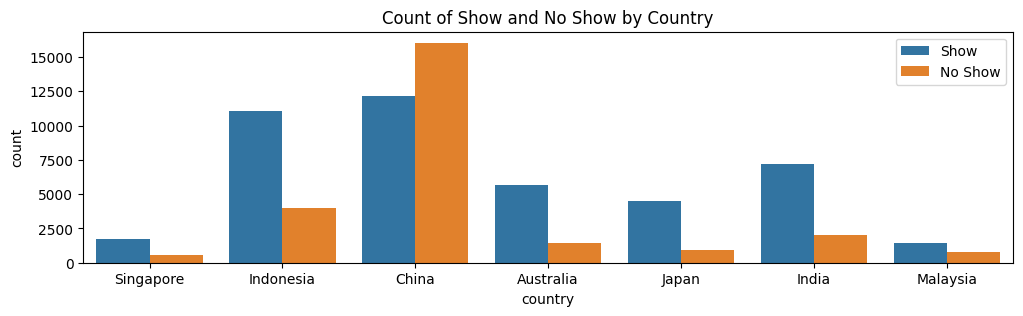

In [140]:
plt.figure(figsize=(12, 3)) 
sb.countplot(x='country', hue='no_show', data=dataCleaned)
plt.title('Count of Show and No Show by Country')
plt.legend(labels=['Show', 'No Show'])
plt.show()

We see a high variation/proportion of Show to No Show across the countries, with China having the greatest number of No Show than Show. This could imply a very strong relationship between 'no_show' and 'country'. This also means that customers from China have a higher tendency of not showing up.

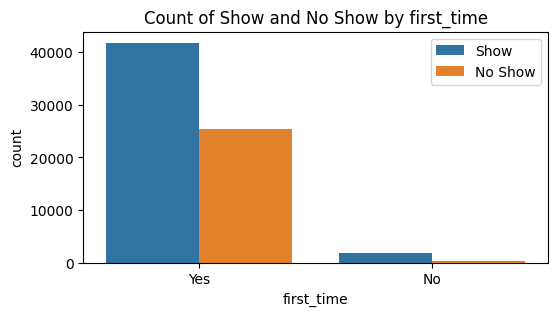

In [141]:
plt.figure(figsize=(6, 3)) 
sb.countplot(x='first_time', hue='no_show', data=dataCleaned)
plt.title('Count of Show and No Show by first_time')
plt.legend(labels=['Show', 'No Show'])
plt.show()

We see that most of the customers booked the hotel for the first time, and there is a higher proportion of No Show for customers that booked the hotel for the first time. This could suggest some relationship between 'no_show' and 'first_time'.

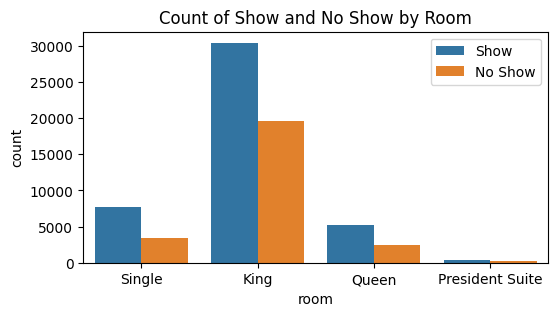

In [142]:
plt.figure(figsize=(6, 3)) 
sb.countplot(x='room', hue='no_show', data=dataCleaned)
plt.title('Count of Show and No Show by Room')
plt.legend(labels=['Show', 'No Show'])
plt.show()

We see that the proportion of No Show for King room is slightly higher as compared to Single and Queen room. This could suggest some relationship between 'no_show' and 'room'. It is hard to justify the proportion of No Show from the President Suite room as the count size is relatively small.

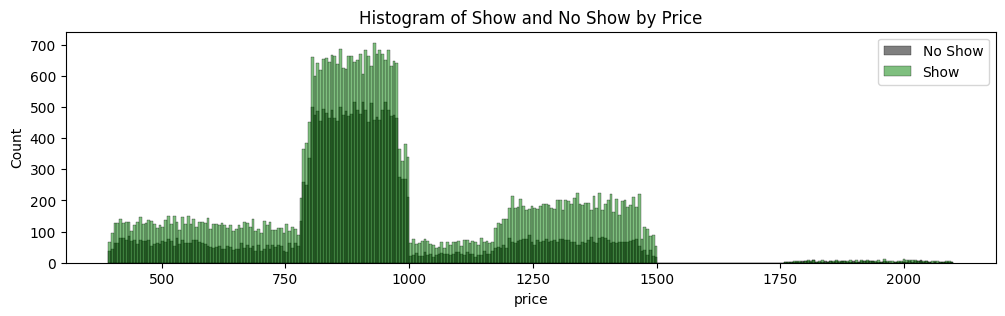

In [143]:
plt.figure(figsize=(12, 3))
sb.histplot(data=dataCleaned, x='price', hue='no_show', bins=300, palette={1.0: 'black', 0.0: 'green'})
plt.title('Histogram of Show and No Show by Price')
plt.legend(labels=['No Show', 'Show'])
plt.show()

The distribution of prices of Show and No Show is very similar, which could suggest no significant relationship between 'no_show' and 'price'.

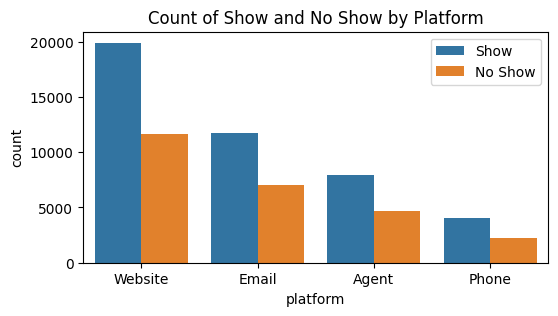

In [144]:
plt.figure(figsize=(6, 3)) 
sb.countplot(x='platform', hue='no_show', data=dataCleaned)
plt.title('Count of Show and No Show by Platform')
plt.legend(labels=['Show', 'No Show'])
plt.show()

We see that the proportion of Show to No Show is about the same across different platforms. This could suggest a weak or no relationship between 'no_show' and 'platform'.

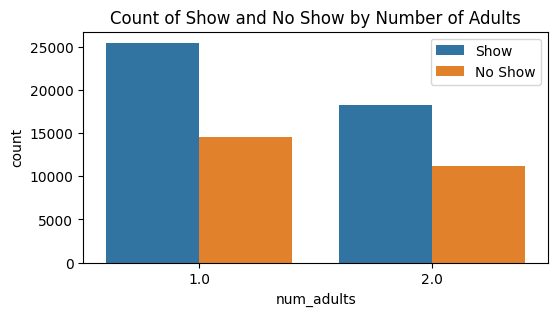

In [145]:
plt.figure(figsize=(6, 3)) 
sb.countplot(x='num_adults', hue='no_show', data=dataCleaned)
plt.title('Count of Show and No Show by Number of Adults')
plt.legend(labels=['Show', 'No Show'])
plt.show()

The proportion of No Show seems to be slightly higher for 2 adults as compared to 1 adult, but intuitively the number of adults should not have a high influence on whether the customers would show up or not.

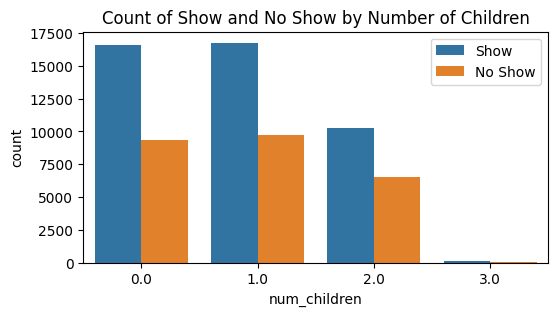

In [146]:
plt.figure(figsize=(6, 3)) 
sb.countplot(x='num_children', hue='no_show', data=dataCleaned)
plt.title('Count of Show and No Show by Number of Children')
plt.legend(labels=['Show', 'No Show'])
plt.show()

The proportion of No Show to Show is slightly higher for customers with 2 children. The proportion of No Show to Show is about the same for customers with 1 and 2 children. It is hard to justify for customers with 3 children as the count size is relatively small.
<br>
<br>
In conclusion, the variables that seem to have an influence on 'no_show' are 'branch', 'country', 'first_time', and 'room' based on the visuals, with 'country' having the most obvious influence on 'no_show'.

<h4> Key findings from the EDA : </h4>
![Screenshot%202024-04-11%20at%203.12.39%E2%80%AFPM.png](attachment:Screenshot%202024-04-11%20at%203.12.39%E2%80%AFPM.png)

Checking for imbalance dataset:

Dataset is not overly skewed towards either show or no show. This shows that dataset is not biased and can be used to build predictive models.

No show being around 37.04% of overall bookings.

Average cancellation rate on Booking.com and Expedia ranged between 25% and 39%. 


<h4>Let's perform Cramer's V Test and Chi-Square Test to confirm our hypothesis.</h4>

Our target variable no_show is a categorical variable. Majority of the features in our dataset are categorical variables. To find relation between two categorical variables we conducted the Cramer’s V test. The input of the Cramer’s V test is the statistic component of the chi square test. Below is the formula for the Cramer’s V test:

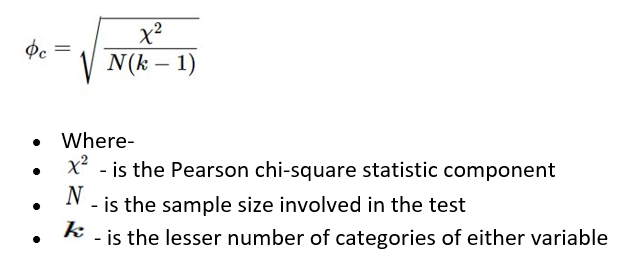

In [147]:
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(confusion_matrix):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

variables = ['branch', 'booking_month', 'arrival_month', 'arrival_day','checkout_month','checkout_day','country','first_time', 'room', 'platform','num_adults','num_children']

results_list = []

# Perform Cramér's V test for each variable
for var in variables:
    contingency_table = pd.crosstab(dataCleaned[var], dataCleaned['no_show'])
    cramers_v_statistic = cramers_v(contingency_table.values)
    
    # Append results to list
    results_list.append({'Variable': var, 'Cramers_V': cramers_v_statistic})

# Create DataFrame from results list
cramers_v_results = pd.DataFrame(results_list)

# Display Cramér's V results
print("Cramér's V Test Results:\n", cramers_v_results)


Cramér's V Test Results:
           Variable  Cramers_V
0           branch   0.137708
1    booking_month   0.037486
2    arrival_month   0.066594
3      arrival_day   0.049388
4   checkout_month   0.064706
5     checkout_day   0.063981
6          country   0.348145
7       first_time   0.084111
8             room   0.071953
9         platform   0.006637
10      num_adults   0.016939
11    num_children   0.023838


In [148]:
from scipy.stats import chi2_contingency

variables = ['branch', 'booking_month', 'arrival_month', 'arrival_day','checkout_month','checkout_day','country','first_time', 'room', 'platform','num_adults','num_children']

results_list = []

# Perform Chi-Square Test for each variable
for var in variables:
    contingency_table = pd.crosstab(dataCleaned[var], dataCleaned['no_show'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Append results to list
    results_list.append({'Variable': var, 'Chi2': chi2})

# Create DataFrame from results list
chi_square_results = pd.DataFrame(results_list)

# Display Chi-Square results
print("Chi-Square Test Results:\n", chi_square_results)

Chi-Square Test Results:
           Variable         Chi2
0           branch  1316.238151
1    booking_month   108.456938
2    arrival_month   318.578296
3      arrival_day   199.172407
4   checkout_month   301.388291
5     checkout_day   313.910383
6          country  8412.274998
7       first_time   491.668926
8             room   362.067572
9         platform     6.055378
10      num_adults    20.900278
11    num_children    42.410799


Higher Chi-Square values indicate a stronger association between the variables and 'no_show', suggesting that they are not independent of each other. Indeed, we observe that 'country', 'branch', 'first_time', and 'room' (descending order of chi-square values) have a significant relationship with 'no_show'.

<h2>Machine Learning</h2>
<h4>Model 1: Binary Logistic Regression</h4>

Logistic Regression is suitable as it takes in two or more predictor variables to predict the outcome of the categorical target variable 'no_show'. In this case, the predictor variables are all categorical. Since the target variable has two outcomes, either show or no show, this is a Binary Logistic Regression.

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, f1_score

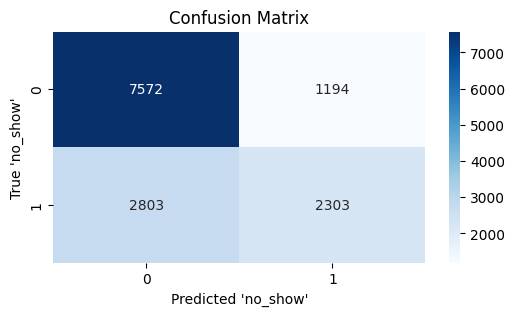


Classification Report:

               precision    recall  f1-score   support

         0.0       0.73      0.86      0.79      8766
         1.0       0.66      0.45      0.54      5106

    accuracy                           0.71     13872
   macro avg       0.69      0.66      0.66     13872
weighted avg       0.70      0.71      0.70     13872

F1 Score: 0.5353946297803092
ROC-AUC Score: 0.729277264050945


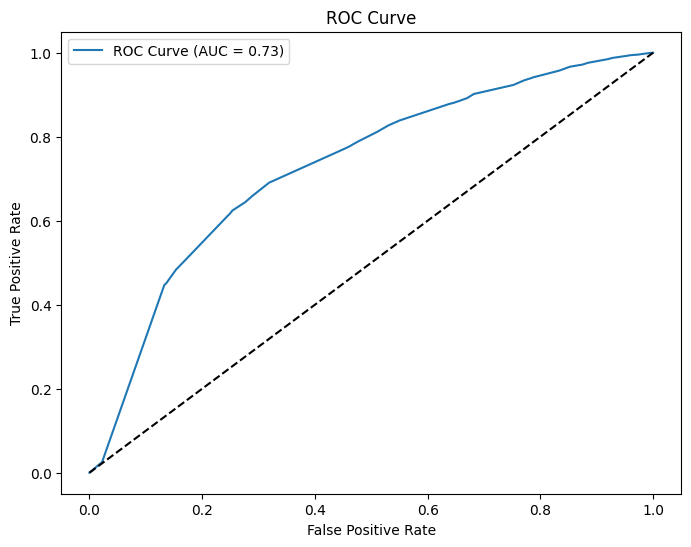

In [150]:
predictors = ['branch', 'country', 'first_time', 'room']

# Create the pipeline with preprocessing and logistic regression
# random_state=42 will be used throughout
pipeline = Pipeline([
    ('preprocessor', OneHotEncoder(handle_unknown='ignore')),
    ('classifier', LogisticRegression(random_state=42)) 
])

# Split the data into 80% training and 20% testing sets
X = dataCleaned[predictors]
y = dataCleaned['no_show']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Plot confusion matrix
plt.figure(figsize=(6, 3))
sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted 'no_show'")
plt.ylabel("True 'no_show'")
plt.show()

# Print classification report
print("\nClassification Report:\n\n", classification_report(y_test, y_pred))
# Calculate and print F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Get predicted probabilities for ROC curve
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

From the Confusion Matrix (0 = Show, 1 = No Show), the regression model uses the test dataset and predicted 7572 entries as Show and 2303 entries as No Show, which turns out to be True. However, it predicted 1194 entries as No Show and 2803 entries as Show, which turns out to be False. This gives the model an overall accuracy of 0.71 when predicting whether customers would show up or not.

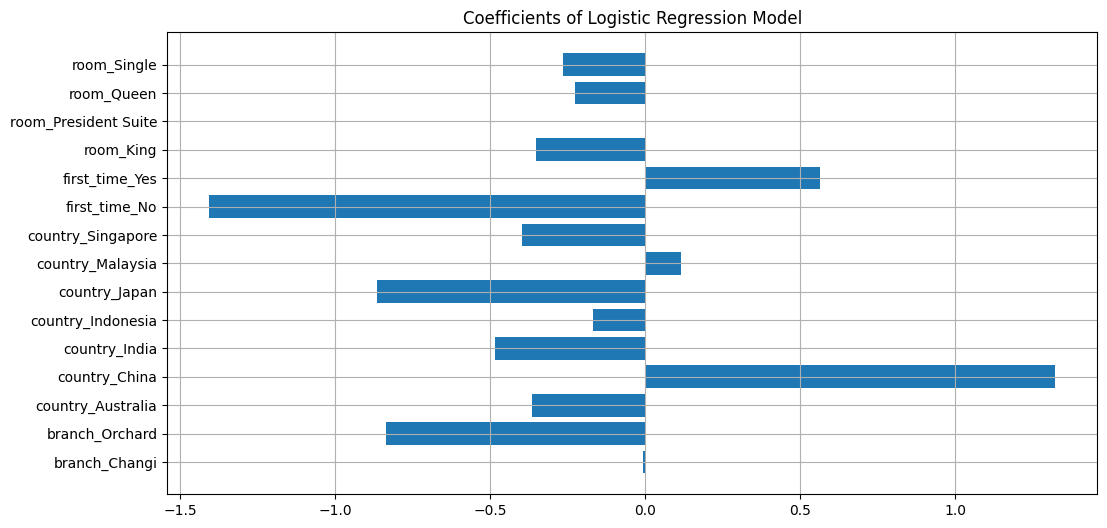

In [151]:
# Get the feature names after one-hot encoding
predictors_names = pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=predictors)

# Get the coefficients from the logistic regression model
coefficients = pipeline.named_steps['classifier'].coef_

# Plot the coefficients
plt.figure(figsize=(12, 6))
plt.barh(predictors_names, coefficients[0])
plt.title('Coefficients of Logistic Regression Model')
plt.grid(True)
plt.show()

The magnitude/value of the coefficient represents the strength of the Predictors' relationship with 'no_show'. A positive coefficient indicates a likelihood of No Show, while a negative coefficient indicates a likelihood of Show.

From the chart, we observe that customers who show up are likely not the first time booking the hotel, or from Japan, or stayed in the Orchard branch. On the other hand, customers who are unlikely to show up are from China or first time booking the hotel.

<h4>Model 2: Multi-Variate Decision Tree</h4>

A Decision Tree is suitable as it provides a clear and interpretable structure that shows how decisions are made based on the predictor variables. This can help us understand the factors influencing the target variable and determine the predictors that have a greater impact on the target variable. Another advantage of Decision tree is that it can capture non-linear relationships between predictors and the target variable.

In [28]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sb

In [29]:
predictors = ['branch', 'country', 'first_time', 'room']

# Encode categorical predictor variables
encoder = LabelEncoder()
X_encoded = X.apply(encoder.fit_transform)

# Split the data into 80% training and 20% testing sets
X = dataCleaned[predictors]
y = dataCleaned['no_show']  
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initialize and train the multivariate decision tree classifier
dt_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

# Plot confusion matrix
plt.figure(figsize=(6, 3))
sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted 'no_show'")
plt.ylabel("True 'no_show'")
plt.show()

# Print classification report
print("\nClassification Report:\n\n", classification_report(y_test, y_pred))

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Plot ROC curve
y_prob = dt_classifier.predict_proba(X_test)[:, 1]
print("ROC_AUC_Score", roc_auc_score(y_test, y_prob))
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc_score(y_test, y_prob))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

NameError: name 'X' is not defined

From the Confusion Matrix (0 = Show, 1 = No Show), the decision tree uses the test dataset and predicted 7433 entries as Show and 2326 entries as No Show, which turns out to be True. However, it predicted 2780 entries as Show and 1333 entries as No Show, which turns out to be False. This gives the model an overall accuracy of 0.7 when predicting the probability of customers showing up.

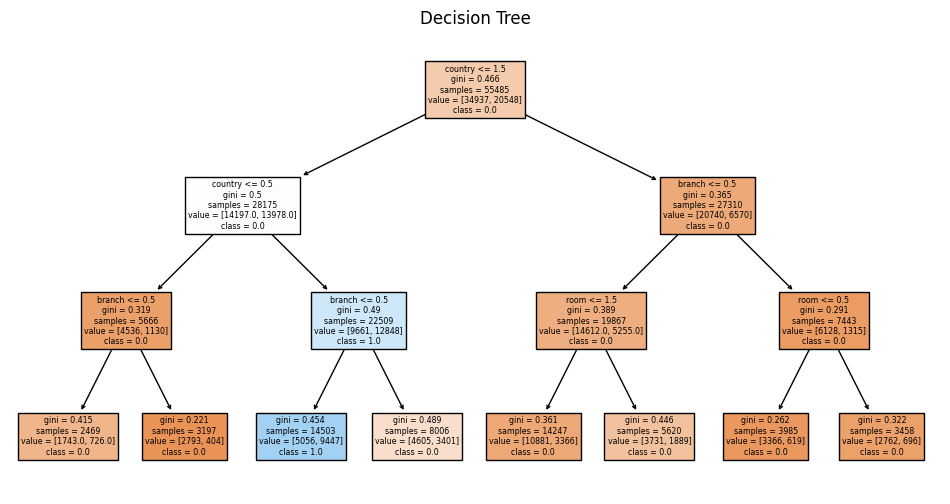

In [154]:
# Plot the decision tree
plt.figure(figsize=(12, 6))

# Convert feature names and class names to strings
feature_names_str = list(map(str, X.columns))
class_names_str = list(map(str, dt_classifier.classes_))

plot_tree(dt_classifier, filled=True, feature_names=feature_names_str, class_names=class_names_str)
plt.title("Decision Tree")
plt.show()

The Decision Tree algorithm evaluates all the categorical predictor variables and selects the variables and split points that would result in the greatest reduction in impurity (gini coefficient) or the highest information gain.

From the Decision Tree, we observe that 'country' exerts the greatest influence on 'no_show' as the model selects it as the root node. The second important variable is 'branch', evidenced by its higher occurrence across the nodes. The third important variable would be 'room' as it appears twice in the nodes.

<h4>Model 3: Random Forest Classification</h4>

Random Forest can capture non-linear relationships between predictor variables and the target variable 'no_show'. It is an ensemble learning method that combines multiple decision trees, each trained on a random subset of the data and variables. This ensemble approach helps reduce overfitting and improves generalization performance compared to a single decision tree.

In [155]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc

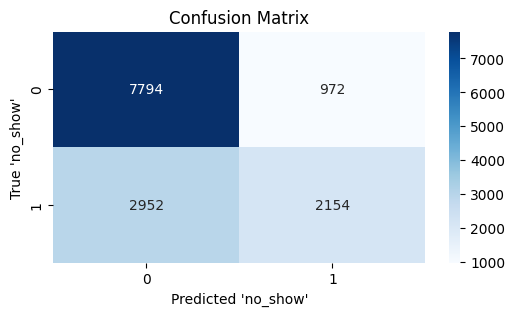


Classification Report:

               precision    recall  f1-score   support

         0.0       0.73      0.89      0.80      8766
         1.0       0.69      0.42      0.52      5106

    accuracy                           0.72     13872
   macro avg       0.71      0.66      0.66     13872
weighted avg       0.71      0.72      0.70     13872

F1 Score: 0.5233236151603499
ROC-AUC Score: 0.7134559789679868


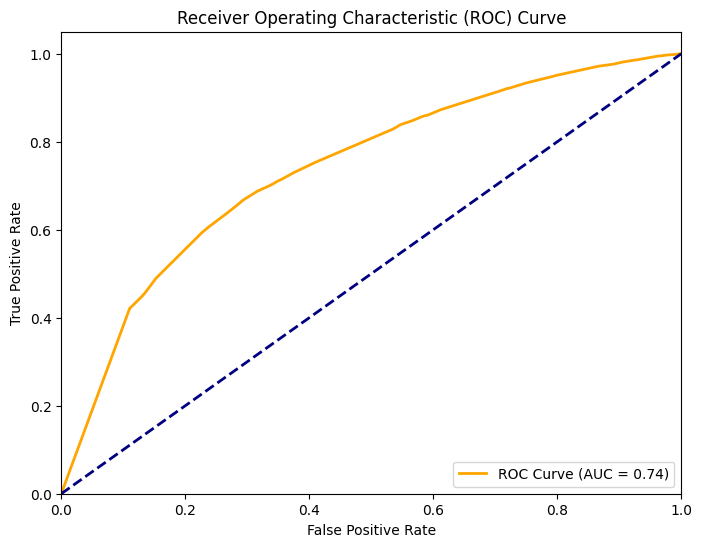

In [156]:
predictors = ['branch', 'country', 'first_time', 'room']

# Encode categorical predictors using one-hot encoding
data_encoded = pd.get_dummies(dataCleaned[predictors])

# Concatenate encoded categorical predictors with the target variable 'no_show'
data_final = pd.concat([data_encoded, dataCleaned['no_show']], axis=1)

# Split data into 80% training and 20% testing sets
X = data_final.drop('no_show', axis=1)
y = data_final['no_show']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot confusion matrix
plt.figure(figsize=(6, 3))
sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted 'no_show'")
plt.ylabel("True 'no_show'")
plt.show()

# Print the classification report
print("\nClassification Report:\n\n",classification_report(y_test, y_pred))

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate ROC-AUC score
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score:", roc_auc)

# Plot ROC curve
y_prob = model.predict_proba(X_test)[:, 1]  # Changed dt_classifier to model
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc_score(y_test, y_prob))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

From the Confusion Matrix (0 = Show, 1 = No Show), the Random Forrest uses the test dataset and predicted 7794 entries as Show and 2154 entries as No Show, which turns out to be True. However, it predicted 2952 entries as Show and 972 entries as No Show, which turns out to be False. This gives the model an overall accuracy of 0.72 (higher than Decision Tree's accuracy) when predicting the probability of customers showing up. Hence, we observe that Random Forest is a better alternative to Decision Tree as it yields a higher accuracy.

<h4>Model 4 : Recurrent Neural Network Model using LSTM architecture</h4>

Using RNN (Recurrent Neural Network) with LSTM (Long Short-Term Memory) architecture is suitable for predicting 'no show' in hotel reservations. 
RNNs, including LSTM, are designed to handle sequential data efficiently. In hotel reservations, data such as booking history, reservation details, and past behavior can be represented as sequences, where each step depends on the previous steps. LSTM can effectively capture dependencies and patterns in such sequential data.

Epoch 1/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6264 - loss: 0.6617 - val_accuracy: 0.6306 - val_loss: 0.6561
Epoch 2/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6613 - loss: 0.6277 - val_accuracy: 0.7078 - val_loss: 0.5907
Epoch 3/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7112 - loss: 0.5849 - val_accuracy: 0.7099 - val_loss: 0.5824
Epoch 4/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7187 - loss: 0.5801 - val_accuracy: 0.7187 - val_loss: 0.5765
Epoch 5/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7172 - loss: 0.5787 - val_accuracy: 0.7187 - val_loss: 0.5750
Epoch 6/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7246 - loss: 0.5720 - val_accuracy: 0.7187 - val_loss: 0.5740
Epoch 7/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7262 - loss: 0.5682 - val_accuracy: 0.7187 - val_loss: 0.5735
Epoch 8/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7209 - loss: 0.5725 - val_accuracy: 0.

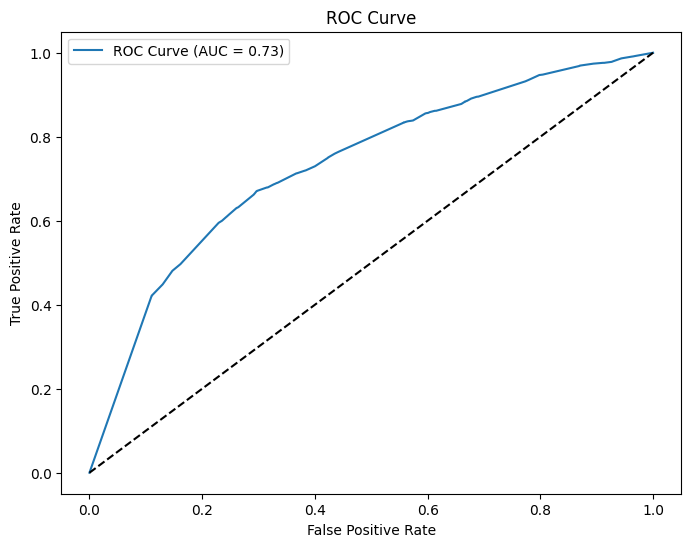

In [159]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Preprocessing: One-hot encode categorical variables
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(dataCleaned[['country', 'branch', 'first_time', 'room']])
y = dataCleaned['no_show']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Define the LSTM model
a=X_encoded.shape[1]
model = Sequential([
    Embedding(input_dim=X_encoded.shape[1], output_dim=32),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Predict classes
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print classification report
print("\nClassification Report:\n\n", classification_report(y_test, y_pred))

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate ROC curve
y_prob = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC score
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


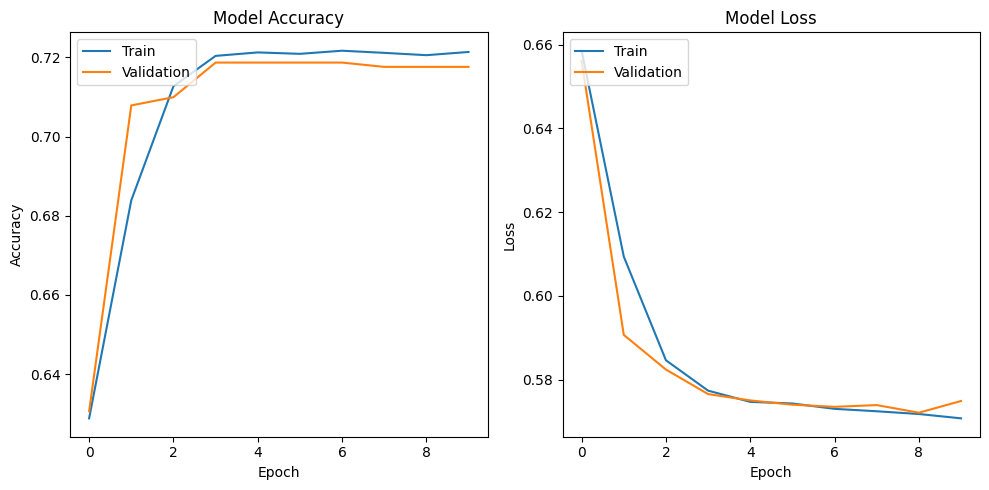

In [160]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

<h4>Model 5 : Convolutional Neural Network and LSTM Hybrid</h4>

A convolutional neural network (CNN or ConvNet) is a network architecture for deep learning that learns directly from data. CNNs are particularly useful for finding patterns in images to recognize objects, classes, and categories. 

Epoch 1/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6743 - loss: 0.6114 - val_accuracy: 0.7176 - val_loss: 0.5714
Epoch 2/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7214 - loss: 0.5700 - val_accuracy: 0.7176 - val_loss: 0.5698
Epoch 3/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7179 - loss: 0.5722 - val_accuracy: 0.7176 - val_loss: 0.5698
Epoch 4/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7186 - loss: 0.5692 - val_accuracy: 0.7176 - val_loss: 0.5706
Epoch 5/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7222 - loss: 0.5669 - val_accuracy: 0.7152 - val_loss: 0.5703
Epoch 6/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7216 - loss: 0.5662 - val_accuracy: 0.7176 - val_loss: 0.5684
Epoch 7/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7265 - loss: 0.5602 - val_accuracy: 0.7152 - val_loss: 0.5688
Epoch 8/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7179 - loss: 0.5700 - val_accuracy: 0.

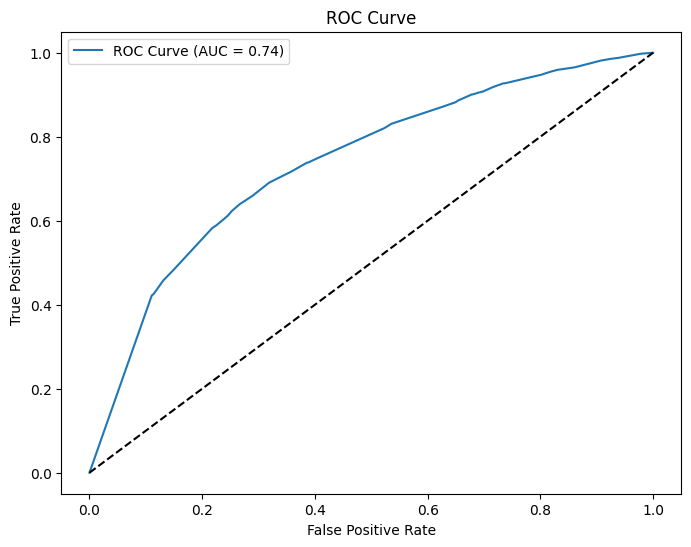

In [161]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Concatenate, Input
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Preprocessing: One-hot encode categorical variables
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(dataCleaned[['country', 'branch', 'first_time', 'room']])
y = dataCleaned['no_show']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Define input tensors
lstm_input = Input(shape=(X_train.shape[1],))
cnn_input = Input(shape=(X_train.shape[1],))

# Define the LSTM model
lstm_output = Sequential([
    Embedding(input_dim=X_encoded.shape[1], output_dim=32),
    LSTM(32)
])(lstm_input)

# Define CNN model
cnn_output = Sequential([
    Embedding(input_dim=X_encoded.shape[1], output_dim=32),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D()
])(cnn_input)

# Combine LSTM and CNN outputs
combined_output = Concatenate()([lstm_output, cnn_output])
combined_output = Dense(64, activation='relu')(combined_output)
output = Dense(1, activation='sigmoid')(combined_output)

model = tf.keras.Model(inputs=[lstm_input, cnn_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit([X_train, X_train], y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate([X_test, X_test], y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Predict probabilities for the ROC curve
y_prob = model.predict([X_test, X_test])

# Print classification report
print("\nClassification Report:\n\n", classification_report(y_test, y_pred))

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC score
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


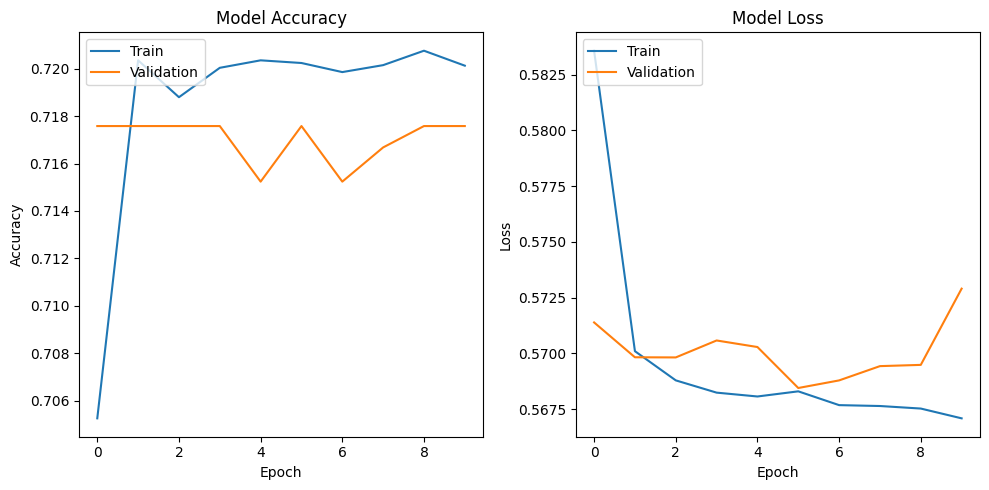

In [162]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

434/434 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Classification Report:

               precision    recall  f1-score   support

         0.0       0.73      0.89      0.80      8766
         1.0       0.69      0.42      0.52      5106

    accuracy                           0.72     13872
   macro avg       0.71      0.66      0.66     13872
weighted avg       0.71      0.72      0.70     13872

F1 Score: 0.5233985656983104
434/434 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
ROC-AUC Score: 0.7381786527175331


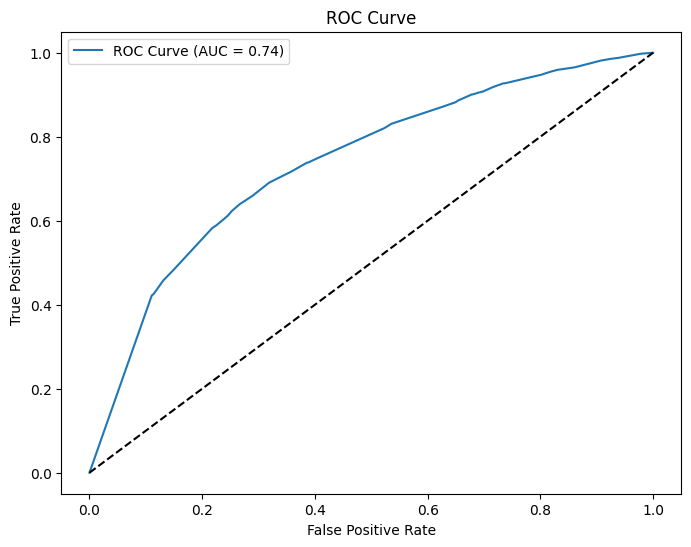

In [163]:
# Predict classes
y_pred = (model.predict([X_test, X_test]) > 0.5).astype("int32")

# Print classification report
print("\nClassification Report:\n\n", classification_report(y_test, y_pred))

# Calculate and print F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Get predicted probabilities for ROC curve
y_pred_proba = model.predict([X_test, X_test])[:, 0]

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


<h3>Step 6 : Statistical Inference </h3>

<h3>Step 7 : Intelligent Decision </h3>

Based on the Machine Learning Models, customers from China or those booking the hotel for the first time have a higher tendency of not showing up. Therefore, to reduce expenses incurred due to No-Shows, the hotel chain could consider implementing a deposit fee that is non-refundable if customers fail to show up for their reservation, particularly for first-time bookings or customers from China.